In [1]:
# Download data and extract into path/data

# %%capture

# !wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n data/train-test-data.zip -d data

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2

In [3]:
keypoints_frame = pd.read_csv('data/training_frames_keypoints.csv')

In [4]:
keypoints_frame = pd.read_csv('data/training_frames_keypoints.csv')

In [5]:
keypoints_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [6]:
# select an image by index n
n = 0
image_name = keypoints_frame.iloc[n, 0]
keypoints = keypoints_frame.iloc[n, 1:]
# change from pandas series to numpy array, reshape to (num_keypoints, 2)
keypoints = keypoints.values.reshape(-1, 2)
print(image_name)
print(keypoints.shape)


Luis_Fonsi_21.jpg
(68, 2)


(192, 176, 4)


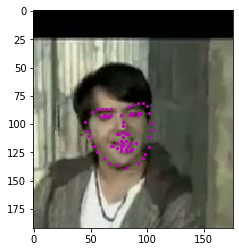

In [7]:
image = mpimg.imread(os.path.join('data/training/', image_name))
print(image.shape)

def plot_face_keypoints(image, keypoints):
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')

plot_face_keypoints(image, keypoints)

In [8]:
# Adapted from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, path_base, transform=None):
        self.keypoints_frame = pd.read_csv(csv_file)
        self.path_base = path_base
        self.transform = transform
        
    def __len__(self):
        return len(self.keypoints_frame)
    
    # read images here instead of init to save memory
    def __getitem__(self, idx):
        """
        Returns a dictionary of:
        {"image": image, "keypoints": keypoints}
        """
        
        image_name = self.keypoints_frame.iloc[idx, 0]
        image = mpimg.imread(os.path.join(self.path_base, image_name))
        
        # if image has an alpha color channel (4th), get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
            
        keypoints = self.keypoints_frame.iloc[idx, 1:]
        # change from pandas series to numpy array, reshape to (num_keypoints, 2)
        keypoints = keypoints.to_numpy().astype('float').reshape(-1, 2)
        
        sample = {"image": image, "keypoints": keypoints}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

In [9]:
data_train = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                   path_base='data/training/')

print("No of training data: ", len(data_train))

No of training data:  3462


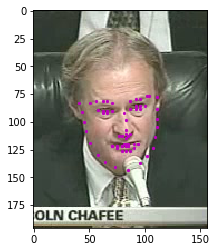

In [10]:
sample = data_train[1]
plot_face_keypoints(sample['image'], sample['keypoints'])

In [11]:
for idx in range(5):
    sample = data_train[idx]
    print("Image shape: ", sample['image'].shape)

Image shape:  (192, 176, 3)
Image shape:  (196, 157, 3)
Image shape:  (190, 170, 3)
Image shape:  (240, 213, 3)
Image shape:  (191, 184, 3)


The shapes of the images are dissimilar, and we'll need to resize them to the same shape before feeding into the neural network.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

In [12]:
class Normalize(object):

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        keypoints_copy = np.copy(keypoints)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        keypoints_copy = (keypoints_copy - 100)/50.0

        return {'image': image_copy, 'keypoints': keypoints_copy}


class Rescale(object):
    def __init__(self, output_size):
        # If tuple, output is matched to output_size. 
        # If int, smaller of image edges is matched to output_size keeping aspect ratio the same.
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        keypoints = keypoints * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': keypoints}


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            #If int, square crop is made
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        keypoints = keypoints - [left, top]

        return {'image': image, 'keypoints': keypoints}


class ToTensor(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(keypoints)}

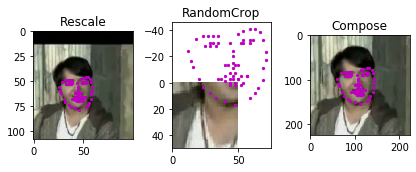

In [13]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
sample = data_train[0]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    plot_face_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [14]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
data_train_trans = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             path_base='data/training/',
                                             transform=data_transform)

print("No of transformed training data: ", len(data_train_trans))

No of transformed training data:  3462


In [15]:
# make sure the sample tensors are the expected size
for i in range(5):
    sample = data_train_trans[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
from src.model import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

In [18]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(data_train_trans, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

In [19]:
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [20]:
def train_net(n_epochs):

    # prepare the net for training
    #net.train()
    
    loss_over_time = []
    
    # move model to GPU
    net.to("cuda")

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            images = images.to('cuda')
            key_pts = key_pts.to('cuda')
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 27 == 26:    # print every 27 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/27))
                
                loss_over_time.append(running_loss/27)
                
                running_loss = 0.0

    print('Finished Training')
    
    return loss_over_time

In [21]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
training_loss = train_net(n_epochs)

Epoch: 1, Batch: 27, Avg. Loss: 0.5579668476625725
Epoch: 1, Batch: 54, Avg. Loss: 0.16745105220211876
Epoch: 2, Batch: 27, Avg. Loss: 0.11467621282294944
Epoch: 2, Batch: 54, Avg. Loss: 0.10065280204569851
Epoch: 3, Batch: 27, Avg. Loss: 0.10489413611314914
Epoch: 3, Batch: 54, Avg. Loss: 0.10200338424355895
Epoch: 4, Batch: 27, Avg. Loss: 0.09834270234461184
Epoch: 4, Batch: 54, Avg. Loss: 0.08956211915722599
Epoch: 5, Batch: 27, Avg. Loss: 0.08595238405245322
Epoch: 5, Batch: 54, Avg. Loss: 0.0836304740773307
Epoch: 6, Batch: 27, Avg. Loss: 0.08355204650649319
Epoch: 6, Batch: 54, Avg. Loss: 0.07797710776880935
Epoch: 7, Batch: 27, Avg. Loss: 0.08151645834247272
Epoch: 7, Batch: 54, Avg. Loss: 0.07165501294312654
Epoch: 8, Batch: 27, Avg. Loss: 0.07440593204012623
Epoch: 8, Batch: 54, Avg. Loss: 0.07030060266455014
Epoch: 9, Batch: 27, Avg. Loss: 0.0705349944807865
Epoch: 9, Batch: 54, Avg. Loss: 0.06776102604689421
Epoch: 10, Batch: 27, Avg. Loss: 0.07383188039616302
Epoch: 10, Bat

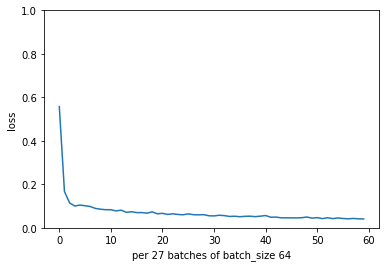

In [22]:
plt.plot(training_loss)
plt.xlabel('per 27 batches of batch_size 64')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.show()

In [23]:
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             path_base='data/test/',
                                             transform=data_transform)

In [24]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

In [25]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        images = images.to("cuda")
        key_pts = key_pts.to("cuda")

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [26]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

test_images = test_images.to("cpu")
test_outputs = test_outputs.to("cpu")
gt_pts = gt_pts.to("cpu")


# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [27]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


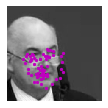

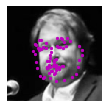

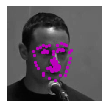

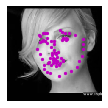

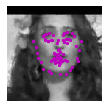

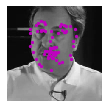

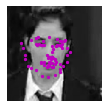

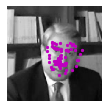

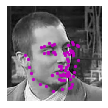

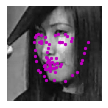

In [30]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    test_images = test_images.to("cpu")
    test_outputs = test_outputs.to("cpu")
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs)

In [29]:
model_dir = 'saved_models/'
model_name = 'naimish_net_30epochs.pt'

torch.save(net.state_dict(), model_dir+model_name)

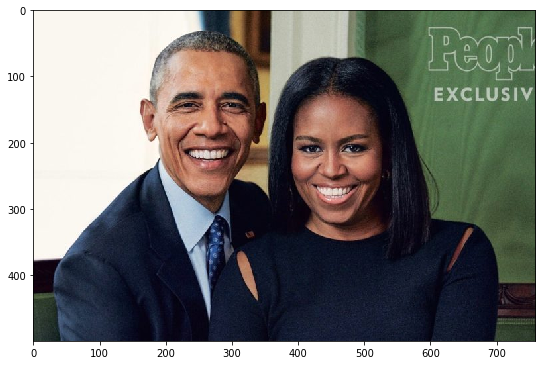

In [31]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

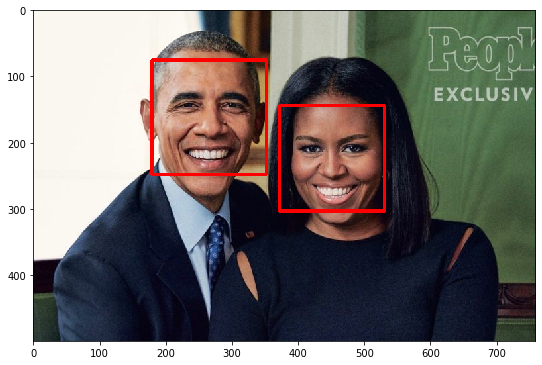

In [33]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [34]:
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

(224, 224)
(68, 2)
(224, 224)
(68, 2)


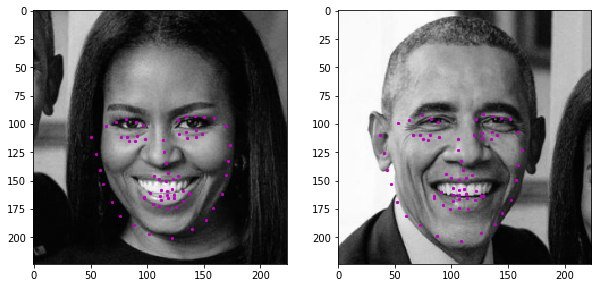

In [42]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
fig = plt.figure(figsize=(10,5))
for i, (x,y,w,h) in enumerate(faces):
    
    # Select the region of interest that is the face in the image
    pad = 50
    roi = image_copy[y-pad:y+h+pad, x-pad:x+w+pad]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    if h > w:
        new_h, new_w = 224* h / w, 224
    elif w > h:
        new_h, new_w = 224, 224* w / h
    else:
        new_h, new_w = 224, 224
    new_h, new_w = int(new_h), int(new_w)

    roi = cv2.resize(roi, (new_w, new_h))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # if image has no grayscale color channel, add one
    if(len(roi.shape) == 2):
        # add that third color dim
        roi_torch = roi.reshape(roi.shape[0], roi.shape[1], 1, 1)
        
    roi_torch = roi_torch.transpose((3, 2, 0, 1))
    roi_torch = torch.from_numpy(roi_torch)
    
    # convert images to FloatTensors
    roi_torch = roi_torch.type(torch.FloatTensor)
    #print(roi.size())
    
    roi_torch = roi_torch.to("cuda")
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    output_pts = net(roi_torch)
    
    output_pts=output_pts.to("cpu")
    
    predicted_key_pts = output_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
    
    #reshape to 68 x 2 pts
    predicted_key_pts = predicted_key_pts[0].reshape((68, 2))
    
    #undo normalization
    predicted_key_pts = predicted_key_pts*50.0+100
    

    ## TODO: Display each detected face and the corresponding keypoints        

    

    fig.add_subplot(1, 2, i+1)
    print(roi.shape)
    print(predicted_key_pts.shape)
    plt.imshow(roi, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    #plt.axis('off')
